# Imports

In [ ]:
import pandas as pd
import json
import dateutil.parser as dparser
from scipy import stats
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Загрузка данных, добавление столбцов, предварительная обработка


In [ ]:
path = '/content/drive/MyDrive/us events ad_revenue filtered 03.02-07.02.csv'
df = pd.read_csv(path)
print(df.columns)

Index(['profile_id', 'os_version', 'device_manufacturer', 'device_model',
       'device_type', 'device_locale', 'event_name', 'event_json',
       'event_datetime', 'event_timestamp', 'event_receive_datetime',
       'event_receive_timestamp', 'connection_type', 'operator_name',
       'country_iso_code', 'city'],
      dtype='object')


Данные **ecpm_sma**, **normalized_ecpm_sma** и **revenue** находятся в словаре в столбце **'event_json'**. Для более удобной работы в датасете я добавил столбцы **'ecpm_sma'**, **'normalized_ecpm_sma'** и **'revenue'**, которые заполнил соответсвующими данными из **'event_json'**.

In [ ]:
ecpm_sma_list = []
normalized_ecpm_sma_list = []
revenue_list = []

for _, row in df.iterrows():
    event_dict = json.loads(row['event_json']) # 'event_json' представляет собой сторку со структурой словаря; для выгрузки данных используется команда json.loads()
    ecpm_sma = event_dict['ecpm_sma']
    normalized_ecpm_sma = event_dict['normalized_ecpm_sma']
    revenue = event_dict['revenue']

    ecpm_sma_list.append(ecpm_sma)
    normalized_ecpm_sma_list.append(normalized_ecpm_sma)
    revenue_list.append(revenue)

df['ecpm_sma'] = ecpm_sma_list
df['normalized_ecpm_sma'] = normalized_ecpm_sma_list
df['revenue'] = revenue_list

Также я добавил столбец **'hour'**, который наполнил данными о часе показа рекламы из столбца **'event_datetime'**.

In [ ]:
print(df['event_datetime'].iloc[0])
time = pd.to_datetime(df['event_datetime'])
df['hour'] = time.dt.hour

2022-02-04 20:02:28


In [ ]:
df.head(3)

,profile_id,os_version,device_manufacturer,device_model,device_type,device_locale,event_name,event_json,event_datetime,event_timestamp,event_receive_datetime,event_receive_timestamp,connection_type,operator_name,country_iso_code,city,ecpm_sma,normalized_ecpm_sma,revenue,hour
0,JLjpGzDHBQm,11,Samsung,Galaxy Tab S6,tablet,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-04 20:02:28,1643994148,2022-02-06 17:58:19,1644159499,wifi,NaN,US,Norwalk,0.511508,0.511508,0.000510,20
1,JLjpGzDHBQm,11,Samsung,Galaxy Tab S6,tablet,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-04 20:02:45,1643994165,2022-02-06 17:58:19,1644159499,wifi,NaN,US,Norwalk,0.511389,0.511389,0.000510,20
2,JLkVacrzHY6,11,Google,Pixel 2,phone,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-05 17:53:05,1644072785,2022-02-06 16:59:29,1644155969,wifi,Verizon,US,Charlotte,0.928597,0.928597,0.002386,17


# 1. Распределения

## 1-a. Построить распределение средних eCPM-ов юзеров

Я не до конца понял процесс нормализации данных **eCPM_sma**, а при вызове описательной статистики видно, что данные **eCPM_sma** и **normalized_eCPM_sma** практически идентичны. Поэтому в ходе работы я буду использовать только **eCPM_sma** для построения распределений.

In [ ]:
df.describe()

,event_timestamp,event_receive_timestamp,ecpm_sma,normalized_ecpm_sma,revenue,hour
count,8.600790e+05,8.600790e+05,860079.000000,860079.000000,860079.000000,860079.000000
mean,1.644088e+09,1.644088e+09,3.147110,3.227661,0.002780,10.282994
std,1.058604e+05,1.055928e+05,15.973978,16.433888,0.015129,7.592752
min,1.643467e+09,1.643836e+09,0.001014,0.001014,0.000000,0.000000
25%,1.644017e+09,1.644018e+09,0.139942,0.139942,0.000046,4.000000
50%,1.644102e+09,1.644103e+09,0.480991,0.480991,0.000494,8.000000
75%,1.644177e+09,1.644177e+09,0.772006,0.772006,0.000533,18.000000
max,1.644268e+09,1.644268e+09,908.876160,917.695618,0.937196,23.000000


Я обратил внимание на тот факт, что 75-ый персентиль у **eCPM_sma** и **revenue** намного меньше максимального значения, что говорит о наличии экстремальных значений. 

In [ ]:
# Какое количество уникальных пользователей?

df['profile_id'].nunique()

4226

3939

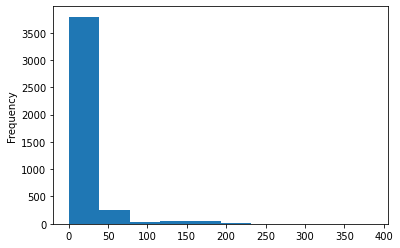

In [ ]:
# Построение распределения средних eCPM юзеров

avg_user_ecpm = df.groupby('profile_id')['ecpm_sma'].mean()
avg_user_ecpm.plot(kind="hist")
avg_user_ecpm.nunique()

Распределение средних eCPM юзеров имеет форму распределения с длинным хвостом. Подавляющее большинство юзеров "приносят" средний eCPM меньше 50, и у малого числа юзеров наблюдаются значения eCPM больше 100.

3868

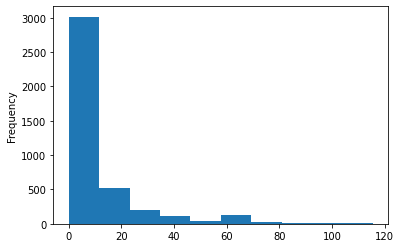

In [ ]:
# Фильтрация значений eCPM, которые не входят в 3 стандартных отклонений. (z оценка > 3)

filtered_avg_user_ecpm = avg_user_ecpm[np.abs(stats.zscore(avg_user_ecpm) < 3)]
filtered_avg_user_ecpm.plot(kind='hist')
filtered_avg_user_ecpm.nunique()

Метод z-оценки помогает отфлитровать экстремальные значения переменной, находящиеся на расстоянии трех стандартных отклонений от среднего значения. При этом было отфильтровано 71 значение. Форма распределения осталась неизменной. 

## 1-b. Отобразить средние eCPM-ы по городам, версиям ОС

Данные о версии ОС находятся в столбце **'os_version'**. Однако стоит учесть, что в данном столбце находятся данные разных производителей ОС. Так столбец **'os_version'** не отражает различие между, к примеру, iOS 11 и Android 11.
Для решения данной проблемы я добавил новый столбец в датасет: **'device_os_version'**, в котором находятся данные версии ОС и производителя ОС.

In [ ]:
# Создание нового столбца из os_version и device_manufacturer -> device_os_version

device_os_version_list = []

for _, row in df.iterrows():
    device = row['device_manufacturer']
    os = row['os_version']
    device_os_version = ' '.join([device, os])
    device_os_version_list.append(device_os_version)
    
df['device_os_version'] = device_os_version_list

In [ ]:
# Какое количество уникальных городов?

df['city'].nunique()

920

In [ ]:
# Какое количество уникальных версий ОС?

df['device_os_version'].nunique()

78

909

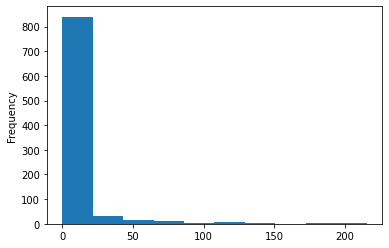

In [ ]:
# Построение распределения eCPM по городам

city_ecpm = df.groupby('city')['ecpm_sma'].mean()
city_ecpm.plot(kind='hist')
city_ecpm.nunique()

Распределение eCPM по городам имеет форму с длинным хвостом. Это означает, что средний eCPM подавляющего большиства городов меньше 50, а также встречаются редкие "аномальные" города, где eCPM превышает 100. Возможно, в таких городах приняты уникальные правила размещения рекламы.

Чтобы посмотреть более детально на основную часть распределения, отфильтруем экстремальные значения.

891

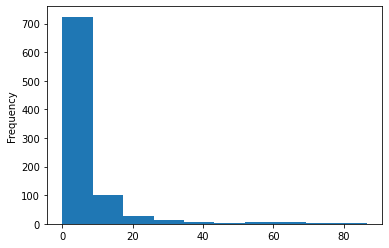

In [ ]:
# Фильтрация значений eCPM, которые не входят в 3 стандартных отклонений. (z оценка > 3)

filtered_city_ecpm= city_ecpm[np.abs(stats.zscore(city_ecpm)) < 3]
filtered_city_ecpm.plot(kind='hist')
filtered_city_ecpm.nunique()

Метод z-оценки отфильтровал 18 значений с наибольшим eCPM. При этом форма распределения осталась неизменной.

Интерсно посмотреть, в каких городах средний eCPM наибольший.

In [ ]:
# Топ-5 городов с наибольшим средним eCPM

city_ecpm.sort_values(ascending=False).head(5)

city
Fredericksburg    215.370667
Owensboro         210.006393
Rohnert Park      209.095016
Baton Rouge       196.173009
Lake Worth        192.047852
Name: ecpm_sma, dtype: float64

Такими городами оказались Фредериксберг, Оуэнсборо и Ронерт-Парк.

78

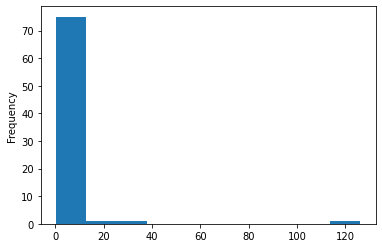

In [ ]:
# Построение распределения средних eCPM по версиям ОС

device_os_ecpm = df.groupby('device_os_version')['ecpm_sma'].mean()
device_os_ecpm.plot(kind='hist')
device_os_ecpm.nunique()

Расперделение средних eCPM по версиям ОС имеет форму распределения с длинным хвостом. Почти все ОС в среднем "приносят" eCPM до 20. Также заметно, что у 1 ОС eCPM больше 120. Возможно, это связано с правилами размещения рекламы на данном ОС.

Чтобы посмотреть более детально на основную часть распределения, отфильтруем экстремальные значения.

77

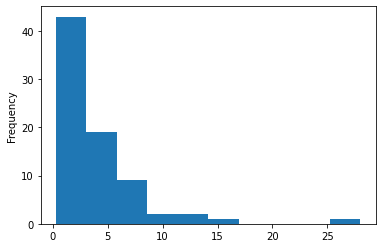

In [ ]:
# Фильтрация значений eCPM, которые не входят в 3 стандартных отклонений. (z оценка > 3)

filtered_device_os_ecpm= device_os_ecpm[np.abs(stats.zscore(device_os_ecpm)) < 3]
filtered_device_os_ecpm.plot(kind='hist')
filtered_device_os_ecpm.nunique()

Метод z-оценки отфильтровал ОС, средний eCPM которой > 120. Форма распределения осталась неизменной.

Интересно выяснить, какая ОС является лидером с точки зрения срелнего eCPM.

In [ ]:
# Единственное отфильтрованное значение

device_os_ecpm.sort_values().tail(1)

device_os_version
AEEZO 10    126.232936
Name: ecpm_sma, dtype: float64

Такой ОС оказался Android 10 на планшетах AEEZO. Однако я затрудняюсь ответить, почему данная ОС имеет наибольший средний eCPM.

## 1-c. Отобразить суммарные доходы по городам, версиям ОС

908

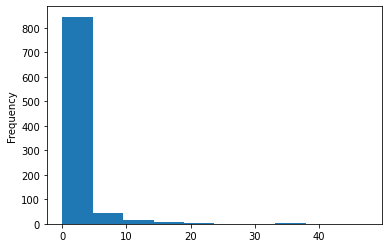

In [ ]:
# Построение распределения доходов по городам

city_revenue = df.groupby('city')['revenue'].sum()
city_revenue.plot(kind='hist')
city_revenue.nunique()

Распределение суммарных доходов по городам обладает формой распределения с длинным хвостом. Подавляющее большинство городов приносит доход в пределах 10, однако наблюдаются редкие, "аномальные" города, в которых доход превышает 30. Я предполагаю, что данные города являются крупными мегаполисами, в которых больше человек смотрит рекламу.

Чтобы посмотреть более детально на основную часть распределения, отфильтруем экстремальные значения.

890

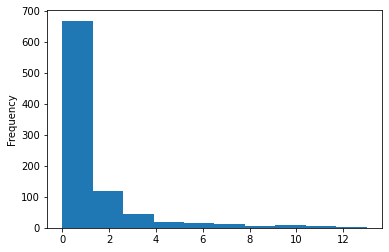

In [ ]:
# Фильтрация значений доходов, которые не входят в 3 стандартных отклонений. (z оценка > 3)

filtered_city_revenue= city_revenue[np.abs(stats.zscore(city_revenue)) < 3]
filtered_city_revenue.plot(kind='hist')
filtered_city_revenue.nunique()

Метод z-оценки отфильтровал 18 городов с наибольшими доходами. При этом форма распределения не изменилась.

Интересно узнать города с наибольшими доходами.

In [ ]:
# Топ-5 городов с наибольшим доходом

city_revenue.sort_values(ascending=False).head(5)

city
New York        47.454397
Indianapolis    36.679515
Houston         34.551763
Minneapolis     34.235291
Cleveland       32.475495
Name: revenue, dtype: float64

Такими городами оказались Нью-Йорк, Индианаполис и Хьюстон. Данные города являются крупными мегаполисами.

78

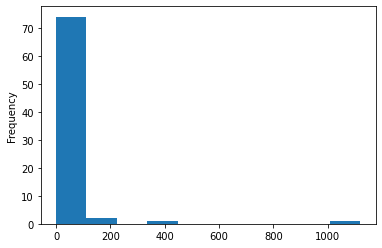

In [ ]:
# Построение распределения доходов по версиям ОС

device_os_revenue = df.groupby('device_os_version')['revenue'].sum()
device_os_revenue.plot(kind='hist')
device_os_revenue.nunique()

Распределение доходов по версиям ОС имеет форму распределения с длинным хвостом. Подавляющее большинство ОС приносит доход меньше 200. Также наблюдается 1 ОС с доходом, превышающим 1,000. Данная ОС, возможно, является наиболее популярной, отчего и приносит наибольший доход.

Чтобы посмотреть более детально на основную часть распределения, отфильтруем экстремальные значения.

77

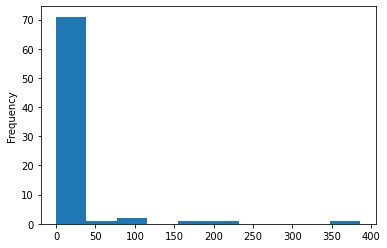

In [ ]:
# Фильтрация значений доходов, которые не входят в 3 стандартных отклонений. (z оценка > 3)

filtered_device_os_revenue= device_os_revenue[np.abs(stats.zscore(device_os_revenue)) < 3]
filtered_device_os_revenue.plot(kind='hist')
filtered_device_os_revenue.nunique()

Метод z-оценки отфильтровал ОС с наибольшим доходом. Форма распределения не изменилась.

Интересно посмотреть на единственное отфильтрованное значение.

In [ ]:
# Единственное отфильтрованное значение

device_os_revenue.sort_values().tail(1)

device_os_version
Samsung 12    1119.788909
Name: revenue, dtype: float64

Выяснилось, что ОС с наибольшим доходом является Android 12 на гаджетах Samsung.

# 2. Учесть статистическую значимость для п.1b (отобразить, отфильтровать незначимое или хотя бы прокомментировать)

В этом пункте мы применим метод z-оценки, только теперь мы сфокусируемся на городах и ОС, которые не попали в 3 стандартных отклонения. 

city
Fredericksburg    215.370667
Owensboro         210.006393
Rohnert Park      209.095016
Baton Rouge       196.173009
Lake Worth        192.047852
Pittsford         189.868790
Amery             189.868790
Santa Fe          189.256317
Cartersville      170.028793
Torrance          129.951996
Santa Ana         129.532799
El Monte          128.959991
Lake Charles      128.959991
Chillicothe       128.959991
Berlin            128.959991
Southfield        128.959991
Waterville        123.530201
Mesquite          122.432091
Suffolk           108.827011
La Crosse         101.527072
Mountain View     101.309395
Keokuk             89.022239
Belle Vernon       88.756658
Name: ecpm_sma, dtype: float64


18

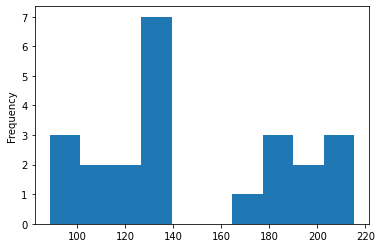

In [ ]:
new_filtered_city_ecpm = city_ecpm[np.abs(stats.zscore(city_ecpm)) > 3].sort_values(ascending=False)
print(new_filtered_city_ecpm)
new_filtered_city_ecpm.plot(kind='hist')
new_filtered_city_ecpm.nunique()

Представлены города, не попавшие в 3 стандартных отклонения распределения средних eCPM по городам. Возможно, высокие средние значения eCPM в данных городах говорят об уникальных правилах размещения рекламы.

Что касается распределения средних eCPM по ОС, как мы уже знаем из пункта 1-b, в 3 стандартных отклонения не попала только Android 10 на планшетах AEEZO. 


```
device_os_version
AEEZO 10    126.232936
```

Аналогично, высокое значение eCPM, возможно, связано с особыми правилами размещения рекламы для данной ОС.

# 3. Описать наблюдения и вывод по исследованию

## 1) Распределение средних eCPM-ов юзеров

Распределение средних eCPM-ов юзеров приняла форму распределения с длинным хвостом. Подавляющее большинство юзеров "приносят" средний eCPM меньше 50, и у малого числа юзеров наблюдаются значения eCPM больше 100.


93% юзера вошли в 3 стандартных отклонения. 

## 2) Отобразить средние CPM-ы по городам, версиям ОС

Распределение eCPM по городам имеет форму с длинным хвостом. Это означает, что средний eCPM подавляющего большиства городов меньше 50, а также встречаются редкие "аномальные" города, где eCPM превышает 100. Возможно, в таких городах приняты уникальные правила размещения рекламы.

98% городов вошли в 3 стандартных отклонения.

Топ-5 городов с наибольшим средним eCPM: Фредериксберг, Оуэнсборо, Ронерт-Парк, Батон Руж и Лейк Ворс.

Расперделение средних eCPM по версиям ОС имеет форму распределения с длинным хвостом. Почти все ОС в среднем "приносят" eCPM до 20. Также заметно, что у 1 ОС eCPM больше 120. Возможно, это связано с правилами размещения рекламы на данном ОС.

99% ОС вошли в 3 стандартных отклонения.

ОС с наибольшим средним eCPM: Android 10 на планшетах AEEZO.

## 3) Отобразить суммарные доходы по городам

Распределение суммарных доходов по городам обладает формой распределения с длинным хвостом. Подавляющее большинство городов приносит доход в пределах 10, однако наблюдаются редкие, "аномальные" города, в которых доход превышает 30. Я предполагаю, что данные города являются крупными мегаполисами, в которых больше человек смотрит рекламу.

98% городов вошли в 3 стнадартных отклонения.

Топ-5 городов с наибольшими доходами: Нью-Йорк, Индианаполис, Хьюстон, Миннеаполис и Кливленд. 

Распределение доходов по версиям ОС имеет форму распределения с длинным хвостом. Подавляющее большинство ОС приносит доход меньше 200. Также наблюдается 1 ОС с доходом, превышающим 1,000. Данная ОС, возможно, является наиболее популярной, отчего и приносит наибольший доход.

99% версий ОС попали в 3 стандартных отклонения.

ОС с наибольшим доходом: Android 12 на Samsung.

# Дополнительные задания:

№ 1. Какой процент доходов содержит информацию о городе юзера?

In [ ]:
# Сравнения числа непустых строк в revenue с общим числом строк

print(len(df[df['revenue'].notna()]))
print(df.shape[0])

860079
860079


Заметим, что число непустых строк в **revenue** совпадает с общим числом строк. Это означает, что во всех строках **revenue** есть данные о доходах, а, значит, для решения задачи нужно всего лишь посчитать количество непустых строк **city**.

In [ ]:
# Отношение количества непустых строк city к общему числу строк, выраженное в процентах

print(round(len(df[df['city'].notna()])/df.shape[0]*100, 2))

62.36


Ответ: 62,36% доходов содержит информацию о городе юзера.

№2. Зависит ли eCPM от времени дня?

Время дня я решил выразить часами из созданного мной в начале работы столбца **'hour'**.

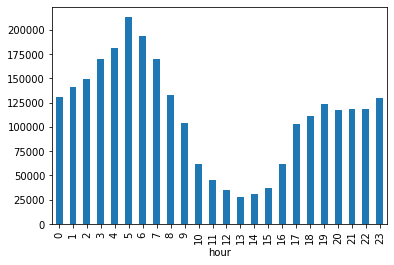

In [ ]:
# Построение распределения eCPM по часам

hour_ecpm = df.groupby('hour')['ecpm_sma'].sum()
hour_ecpm.plot(kind='bar')

На данной столбцовой диаграмме видна зависимость между суммарным eCPM и часом, в который реклама была показана. Распределение близко к нормальному с пиком в 5 часов утра.

In [ ]:
# Добавление нового столбца time_of_day

daytime_list = ['night', 'morning', 'day', 'evening']
time_of_day_list = []

for _, row in df.iterrows():
    hour = row['hour']
    if hour < 6:
      time_of_day_list.append(daytime_list[0])
    elif hour < 12:
      time_of_day_list.append(daytime_list[1])
    elif hour < 18:
      time_of_day_list.append(daytime_list[2])
    else:
      time_of_day_list.append(daytime_list[3])
    
df['time_of_day'] = time_of_day_list
df['time_of_day'].head()

0    evening
1    evening
2        day
3        day
4        day
Name: time_of_day, dtype: object

Я также решил показать распределение eCPM относительно времени дня. Для этого я создал столбец **'time_of_day'**. Я решил определить премя дня следующим образом: с 0 до 6 часов — ночь, с 6 до 12 часов — утро, с 12 до 18 часов — день, с 18 до 24 часов — вечер.

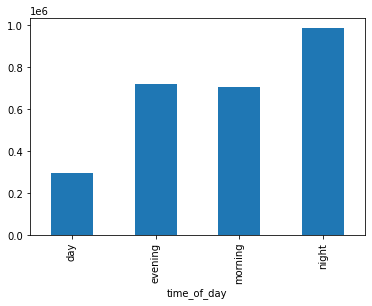

In [ ]:
# Построение распределения eCPM по времени суток

time_of_day_ecpm = df.groupby('time_of_day')['ecpm_sma'].sum()
time_of_day_ecpm.plot(kind='bar')

Видно, что ночью реклама приносит наибольший eCPM.